In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:04<00:00, 41.4MB/s]
100% 2.29G/2.29G [01:04<00:00, 38.4MB/s]


In [ ]:
import numpy as np
from tensorflow.keras import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 

### __Defining Constants__


In this part, constant values are defined in order to make the code more readable and more flexible to change.

In [ ]:
class_number = 2
train_path = "/content/gdrive/MyDrive/chest_xray/train"
test_path = "/content/gdrive/MyDrive/chest_xray/test"

In [ ]:
!cp "/content/gdrive/MyDrive/chest-xray-pneumonia.zip" .

cp: '/content/gdrive/MyDrive/chest-xray-pneumonia.zip' and './chest-xray-pneumonia.zip' are the same file


In [ ]:
!unzip /content/gdrive/MyDrive/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
generate_data = preprocessing.image.ImageDataGenerator()

In [ ]:
def export_data(generate_data,file):
    data = generate_data.flow_from_directory(file,target_size = (80, 80),color_mode = "grayscale",batch_size = 32)
    return data

In this part, we printed the number of instances of each class in test and train data.

In [ ]:
train_data = export_data(generate_data, train_path)

Found 5216 images belonging to 2 classes.


In [ ]:
test_data = export_data(generate_data, test_path)

Found 624 images belonging to 2 classes.


### __Question 2: Visualization__

#### __Plotting a Sample of each Class__

In [ ]:
images, labels = train_data.next()

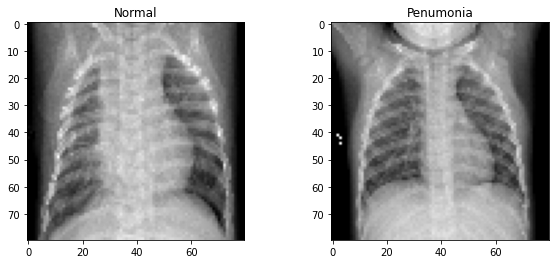

In [ ]:
picture, axis = plot_container = plt.subplots(1, 2)
picture.set_size_inches(10, 4)
pointer = 0
l_dict = {0:'Penumonia', 1:'Normal'}
figures_done = list()

for image, label in zip(images, labels):
    label_of_each_class = backend.argmax(label).numpy()
    if label_of_each_class not in figures_done:
        axis[pointer].imshow(image.reshape(80, 80), cmap='gray')
        axis[pointer].set_title(l_dict[label_of_each_class])
        figures_done.append(label_of_each_class)
        pointer += 1

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


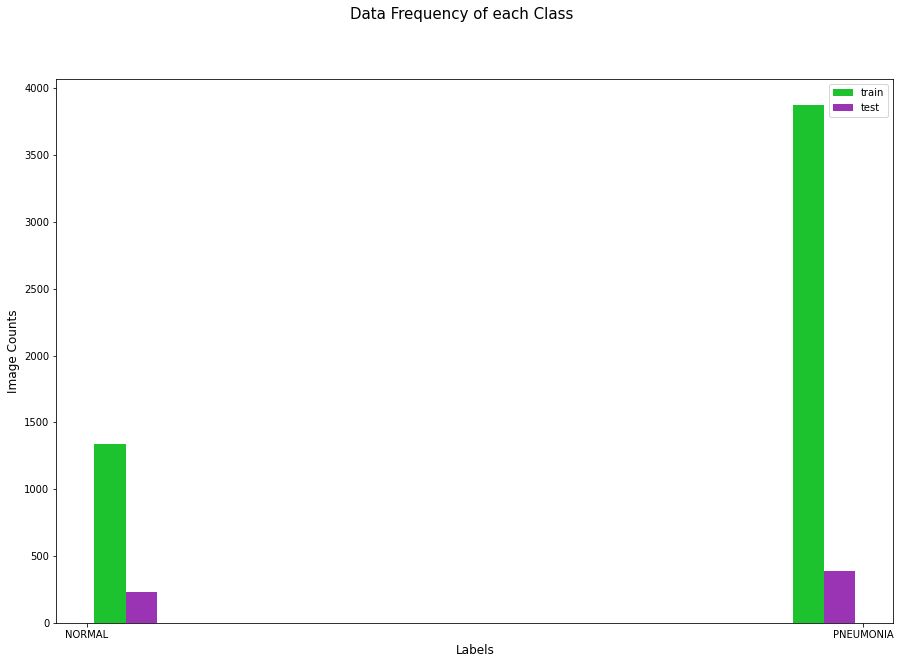

In [ ]:
picture = plt.figure(figsize=(15, 10))
labels = (train_data.classes, test_data.classes)
plt.hist(labels, label=['train', 'test'], color=['#1cc32f', '#9a34b5'])
plt.xlabel('Labels', fontsize = 12)
plt.ylabel('Image Counts', fontsize = 12)
plt.suptitle('Data Frequency of each Class', fontsize = 15)
plt.legend()
tmp = list(train_data.class_indices.values())
tpm_1 = list(train_data.class_indices.keys())
plt.xticks(tmp, tpm_1)
plt.show()

### __Question 3__
In this part, we implemented necessary functions to make a neural network with and without dropout layers. Also, we set default values for some hyperparameters based on the project description.

In [ ]:
def neural_network_drop(n_1, n_2, n_3, dropout, \
                                          activation='relu', optimizer=optimizers.SGD(), \
                                          loss=losses.categorical_crossentropy, regularizer=None):
    input  = layers.Input(shape=(80, 80, 1))
    output = layers.Flatten()(input)
    output = layers.Dense(n_1, activation=activation, kernel_regularizer=regularizer)(output)
    output = layers.Dropout(dropout)(output)
    output = layers.Dense(n_2, activation=activation, kernel_regularizer=regularizer)(output)
    output = layers.Dropout(dropout)(output)
    output = layers.Dense(n_3, activation=activation, kernel_regularizer=regularizer)(output)
    output = layers.Dropout(dropout)(output)
    output = layers.Dense(class_number, activation="softmax")(output)

    train_model = models.Model(inputs=input, outputs=output) 
    train_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  
    return train_model

In [ ]:
def neural_network(n_1, n_2, n_3, activation='relu', optimizer=optimizers.SGD(), loss=losses.categorical_crossentropy, regularizer=None):
    input = layers.Input(shape=(80, 80, 1))
    output = layers.Flatten()(input)
    output = layers.Dense(n_1, activation=activation, kernel_regularizer=regularizer)(output)
    output = layers.Dense(n_2, activation=activation, kernel_regularizer=regularizer)(output)
    output = layers.Dense(n_3, activation=activation, kernel_regularizer=regularizer)(output)
    output = layers.Dense(class_number, activation="softmax")(output)

    train_model = models.Model(inputs=input, outputs=output) 
    train_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  
    return train_model

#### __Constructing FeedForward Neural Network__

In [ ]:
relu_model = neural_network(4800, 3200, 1600)                                       

#### __Parameters of the Model__
In this part, we use `summary()` method to check the parameters of our model. 

Each row represents a layer with each named uniquely such that we can refer to these layers without any ambiguity. As you can see, the layers that we added to the model in the previous code snippet are all included in the output.


Each layer has an output and its shape is shown in the **Output Shap** column Each layer’s output becomes the input for the subsequent layer.


The **Param #** column shows the number of parameters that are trained for each layer.


The total number of parameters is shown at the end, which is equal to the number of trainable and non-trainable parameters. In this model, all the parmeters are trainable.


In [ ]:
relu_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 6400)              0         
                                                                 
 dense_12 (Dense)            (None, 4800)              30724800  
                                                                 
 dense_13 (Dense)            (None, 3200)              15363200  
                                                                 
 dense_14 (Dense)            (None, 1600)              5121600   
                                                                 
 dense_15 (Dense)            (None, 2)                 3202      
                                                                 
Total params: 51,212,802
Trainable params: 51,212,802
Non-t

The number of parameters for each layer can be computed using the following formula:

_*# of parameters = (# of inputs + 1) * (# of outputs)*_

1 in the above formula refers to the bias term and the product shows the number of edges from the previous layer to the current layer. We need to compute the weights of these edges in our training process.



### __Question 4__

#### __Defining Methods for Training__

In [ ]:
def put_label(data):
    tmp = []
    for i in range(int(np.ceil(len(data.classes)/data.batch_size))):
        images, labels = data.next()
        for label in labels:
            tmp = np.append(tmp , backend.argmax(label))
        tmp = np.array(tmp)
    return tmp

In [ ]:
def metrics (true, result):
    true = np.array(backend.argmax(true))
    print(classification_report(result, true))

In [ ]:
def prediction(tr, test_data):
    result = put_label(test_data)
    true = tr.predict(test_data)
    metrics(true, result)

In [ ]:
def loss (history):
    picture = plt.figure(figsize=(15, 10))
    plt.plot(history.history['loss'], linewidth = 3, color = '#e500a9')
    plt.plot(history.history['val_loss'], linewidth = 3, color = '#9a34b5')
    plt.title('Model Loss', fontsize = 15)
    plt.ylabel('Loss', fontsize = 12)
    plt.xlabel('Epoch', fontsize = 12)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

#### __Training with ReLU Activation Function__
When we use this activation function, we face with the nan loss values and this happend because we did not normalize the photos in the previous parts. Moreover, we have died relu and the accuracy of our model is not updating. 

In [ ]:
history = relu_model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
163/163 [==============================] - 57s 353ms/step - loss: nan - accuracy: 0.2571 - val_loss: nan - val_accuracy: 0.3750
Epoch 2/10
163/163 [==============================] - 54s 333ms/step - loss: nan - accuracy: 0.2571 - val_loss: nan - val_accuracy: 0.3750
Epoch 3/10
163/163 [==============================] - 54s 334ms/step - loss: nan - accuracy: 0.2571 - val_loss: nan - val_accuracy: 0.3750
Epoch 4/10
163/163 [==============================] - 54s 331ms/step - loss: nan - accuracy: 0.2571 - val_loss: nan - val_accuracy: 0.3750
Epoch 5/10
163/163 [==============================] - 54s 331ms/step - loss: nan - accuracy: 0.2571 - val_loss: nan - val_accuracy: 0.3750
Epoch 6/10
163/163 [==============================] - 54s 329ms/step - loss: nan - accuracy: 0.2571 - val_loss: nan - val_accuracy: 0.3750
Epoch 7/10
163/163 [==============================] - 56s 345ms/step - loss: nan - accuracy: 0.2571 - val_loss: nan - val_accuracy: 0.3750
Epoch 8/10
163/163 [=======

In [ ]:
prediction(relu_model, test_data)

In [ ]:
loss(history)

#### __Training with Tanh Activation Function__

When we use the tanh activation function, gradients get smaller and smaller during the time. Therefore, neurons of the first layers do the learning process slower than neurons of the last layers. This can make the learning process longer. As a result, the accuracy of the model will be reduced.


In [ ]:
tanh_train_model = neural_network(4800, 3200, 1600, activation='tanh')                                       

In [ ]:
all_data = tanh_train_model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
163/163 [==============================] - 55s 332ms/step - loss: 1.1665 - accuracy: 0.6453 - val_loss: 0.7772 - val_accuracy: 0.3750
Epoch 2/10
163/163 [==============================] - 54s 329ms/step - loss: 0.7151 - accuracy: 0.6716 - val_loss: 0.8222 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 53s 328ms/step - loss: 0.6696 - accuracy: 0.6806 - val_loss: 0.7022 - val_accuracy: 0.3750
Epoch 4/10
163/163 [==============================] - 55s 337ms/step - loss: 0.6325 - accuracy: 0.7136 - val_loss: 0.6964 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 56s 345ms/step - loss: 0.6189 - accuracy: 0.7251 - val_loss: 0.6606 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 54s 332ms/step - loss: 0.6180 - accuracy: 0.7159 - val_loss: 0.7194 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 54s 330ms/step - loss: 0.6044 - accuracy: 0.7249 - val_loss: 0.7254 - val_ac

In [ ]:
prediction(tanh_train_model, test_data)

20/20 [==============================] - 5s 250ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       234
         1.0       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


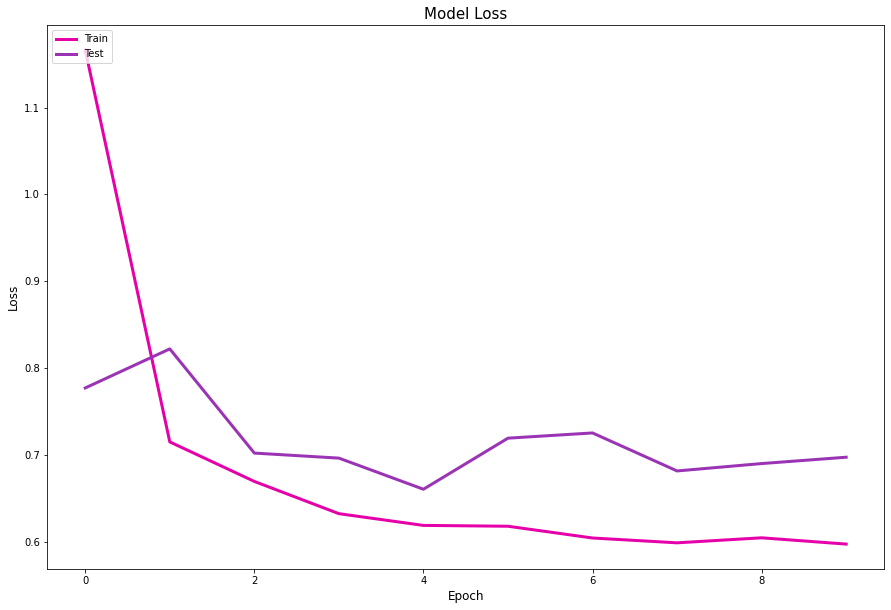

In [ ]:
loss(all_data)

#### __Comparison between Two Activation Functions__
In both, our model is not updating and it seems that the process of training has been stopped. But the loss for the relu gets nan value and this refers to the definition of this function.

One technique to deal with this problem is to normalize the data before learning.

### __Question 5__
In this part, we normalize data and set the number of hidden layers and the number of neurons in each layer to reach an optimal model. The F1-Score of our model is 0.96.

In [ ]:
scale_data = preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_scale = export_data(scale_data, train_path)

Found 5216 images belonging to 2 classes.


In [ ]:
test_scale = export_data(scale_data, test_path)

Found 624 images belonging to 2 classes.


In [ ]:
opt_train_model = neural_network(4800, 3200, 1600)                                       
all_data = opt_train_model.fit(train_scale, validation_data=test_scale, epochs=10)

Epoch 1/10
163/163 [==============================] - 57s 338ms/step - loss: 0.4019 - accuracy: 0.8276 - val_loss: 0.7998 - val_accuracy: 0.6410
Epoch 2/10
163/163 [==============================] - 55s 340ms/step - loss: 0.2491 - accuracy: 0.9061 - val_loss: 0.8831 - val_accuracy: 0.6763
Epoch 3/10
163/163 [==============================] - 56s 342ms/step - loss: 0.2003 - accuracy: 0.9212 - val_loss: 0.4275 - val_accuracy: 0.7981
Epoch 4/10
163/163 [==============================] - 55s 336ms/step - loss: 0.1717 - accuracy: 0.9331 - val_loss: 0.8258 - val_accuracy: 0.7099
Epoch 5/10
163/163 [==============================] - 57s 351ms/step - loss: 0.1540 - accuracy: 0.9427 - val_loss: 0.6840 - val_accuracy: 0.7548
Epoch 6/10
163/163 [==============================] - 55s 337ms/step - loss: 0.1538 - accuracy: 0.9429 - val_loss: 0.8192 - val_accuracy: 0.7260
Epoch 7/10
163/163 [==============================] - 54s 334ms/step - loss: 0.1253 - accuracy: 0.9511 - val_loss: 1.1525 - val_ac

In [ ]:
prediction(opt_train_model, test_scale)

20/20 [==============================] - 5s 249ms/step
              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       234
         1.0       0.88      0.85      0.87       390

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



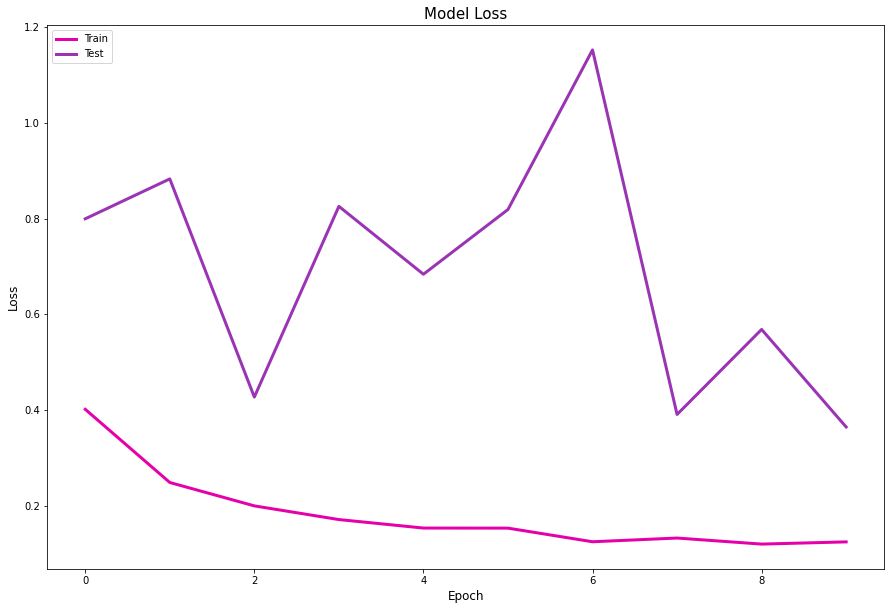

In [ ]:
loss(all_data)

### __Question 6__

#### __What is momentum in neural networks?__
Momentum or SGD with momentum is a method which helps us to accelerate gradient vectors in the right directions. Momentum is an average of gradients that changes during the time and we use it to update weight in each step. Therefore, it leads to faster convergence. It is mostly used in neural networks considering the size of data in NNs makes a considerable time difference while training gradients. It can be used to handle noisy gradients. Moreover, it can handle extremely small gradients.


#### __Is it always good to set momentum to a larger number?__
Momentum or SGD with momentum is a method which helps us to accelerate gradient In fact, momentum makes each step of the learning process dependent on its previous. If we set momentum and learning rate to large values, we will have bigger steps, and based on the dependency that we mentioned above, the next steps will be larger and larger. As a result, weights won't be updated in a correct way, and they will never reach optimal values. Therefore, large momentum does not necessarily lead to higher accuracies.

#### __Setting Momentum to 0.5__

In [ ]:
momentum_50_train_model = neural_network(4800, 3200, 1600, optimizer=optimizers.SGD(momentum=0.5))  
all_data = momentum_50_train_model.fit(train_scale, validation_data=test_scale, epochs=10)

Epoch 1/10
163/163 [==============================] - 56s 340ms/step - loss: 0.3323 - accuracy: 0.8664 - val_loss: 0.3692 - val_accuracy: 0.8301
Epoch 2/10
163/163 [==============================] - 57s 347ms/step - loss: 0.1904 - accuracy: 0.9214 - val_loss: 0.5774 - val_accuracy: 0.7788
Epoch 3/10
163/163 [==============================] - 56s 341ms/step - loss: 0.1643 - accuracy: 0.9340 - val_loss: 0.3382 - val_accuracy: 0.8478
Epoch 4/10
163/163 [==============================] - 56s 344ms/step - loss: 0.1531 - accuracy: 0.9394 - val_loss: 0.7385 - val_accuracy: 0.7244
Epoch 5/10
163/163 [==============================] - 58s 357ms/step - loss: 0.1371 - accuracy: 0.9461 - val_loss: 0.6404 - val_accuracy: 0.7724
Epoch 6/10
163/163 [==============================] - 56s 343ms/step - loss: 0.1223 - accuracy: 0.9515 - val_loss: 1.0134 - val_accuracy: 0.7163
Epoch 7/10
163/163 [==============================] - 56s 342ms/step - loss: 0.1167 - accuracy: 0.9528 - val_loss: 0.7674 - val_ac

In [ ]:
prediction(momentum_50_train_model, test_scale)

20/20 [==============================] - 5s 253ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.43      0.59       234
         1.0       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



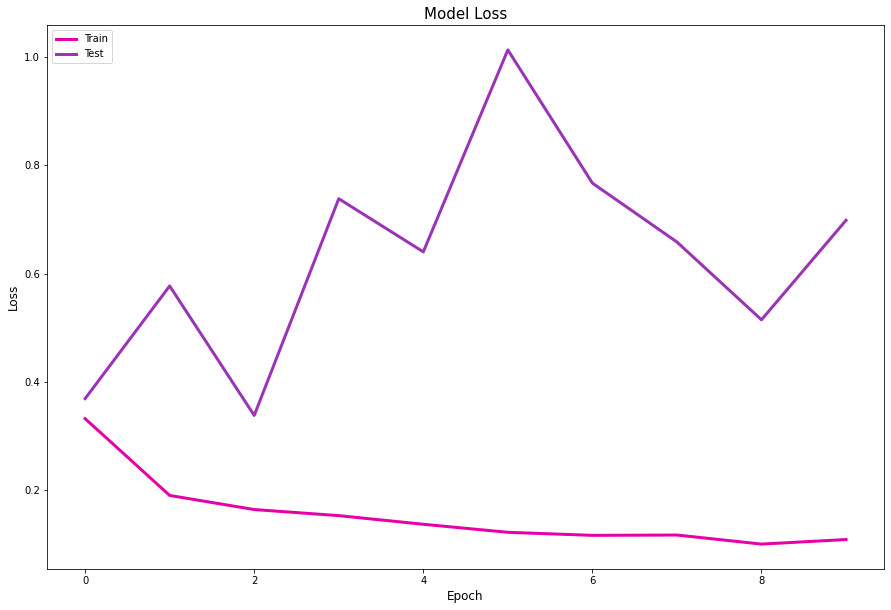

In [ ]:
loss(all_data)

Based on the result, this model is more optimal in comparison to the other model (with another values for momentum) and the loss decreases with higher rate.

#### __Setting Momentum to 0.9__

In [ ]:
momentum_90_train_model = neural_network(4800, 3200, 1600, optimizer=optimizers.SGD(momentum=0.9))  
all_data = momentum_90_train_model.fit(train_scale, validation_data=test_scale, epochs=10)

Epoch 1/10
163/163 [==============================] - 59s 362ms/step - loss: 0.2916 - accuracy: 0.8777 - val_loss: 1.0757 - val_accuracy: 0.7083
Epoch 2/10
163/163 [==============================] - 56s 342ms/step - loss: 0.1870 - accuracy: 0.9220 - val_loss: 0.8295 - val_accuracy: 0.6987
Epoch 3/10
163/163 [==============================] - 57s 352ms/step - loss: 0.1568 - accuracy: 0.9373 - val_loss: 0.6033 - val_accuracy: 0.7997
Epoch 4/10
163/163 [==============================] - 55s 340ms/step - loss: 0.1523 - accuracy: 0.9410 - val_loss: 0.6491 - val_accuracy: 0.7885
Epoch 5/10
163/163 [==============================] - 56s 342ms/step - loss: 0.1333 - accuracy: 0.9490 - val_loss: 0.6334 - val_accuracy: 0.7804
Epoch 6/10
163/163 [==============================] - 55s 340ms/step - loss: 0.1351 - accuracy: 0.9477 - val_loss: 0.5002 - val_accuracy: 0.8173
Epoch 7/10
163/163 [==============================] - 55s 340ms/step - loss: 0.1312 - accuracy: 0.9467 - val_loss: 0.8257 - val_ac

In [ ]:
prediction(momentum_90_train_model, test_scale)

20/20 [==============================] - 5s 253ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.40      0.56       234
         1.0       0.73      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.77      0.74       624



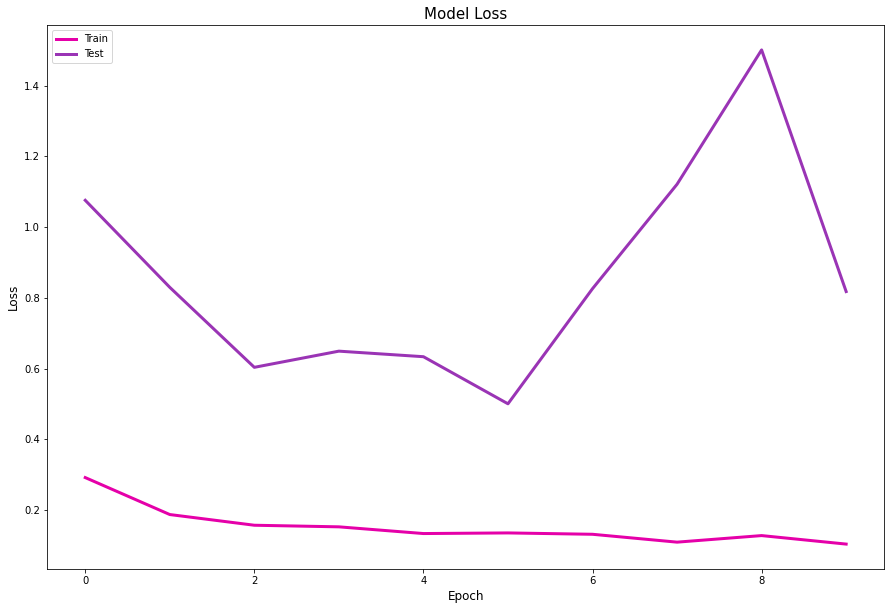

In [ ]:
loss(all_data)

Based on the result, using 0.9 for momentum does not have any positive effect and the rate of the changing in loss has been decreased.

#### __Setting Momentum to 0.99__

In [ ]:
momentum_99_train_model = neural_network(4800, 3200, 1600, optimizer=optimizers.SGD(momentum=0.99))  
all_data = momentum_99_train_model.fit(train_scale, validation_data=test_scale, epochs=10)

Epoch 1/10
163/163 [==============================] - 55s 338ms/step - loss: 0.6504 - accuracy: 0.7621 - val_loss: 0.4632 - val_accuracy: 0.8205
Epoch 2/10
163/163 [==============================] - 55s 338ms/step - loss: 0.8841 - accuracy: 0.7772 - val_loss: 1.5550 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 55s 339ms/step - loss: 0.7367 - accuracy: 0.7071 - val_loss: 0.6880 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 55s 337ms/step - loss: 0.5915 - accuracy: 0.7396 - val_loss: 0.7197 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 57s 352ms/step - loss: 0.4796 - accuracy: 0.7820 - val_loss: 0.4425 - val_accuracy: 0.7917
Epoch 6/10
163/163 [==============================] - 55s 337ms/step - loss: 0.8746 - accuracy: 0.7301 - val_loss: 1.0418 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 55s 335ms/step - loss: 0.6235 - accuracy: 0.7314 - val_loss: 0.7427 - val_ac

In [ ]:
prediction(momentum_99_train_model, test_scale)

20/20 [==============================] - 5s 251ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       234
         1.0       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


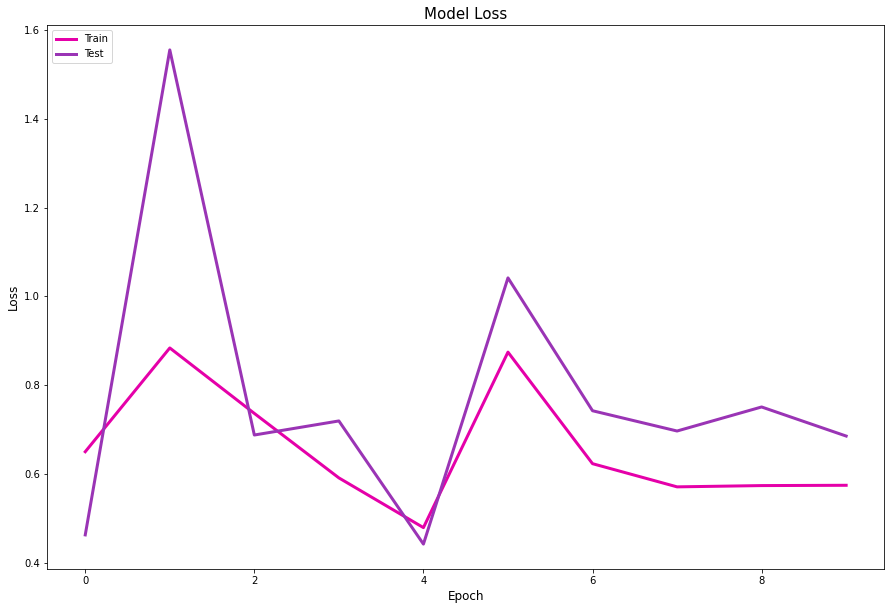

In [ ]:
loss(all_data)

Base on the result, the weights in this model are not updating in a correct direction and it seems that this model will not reach to an optimal solution.

#### __Using Adam Optimizer__

In [ ]:
adam_train_model = neural_network(4800, 3200, 1600, optimizer=optimizers.Adam())  
all_data = adam_train_model.fit(train_scale, validation_data=test_scale, epochs=10)

Epoch 1/10
163/163 [==============================] - 56s 341ms/step - loss: 0.8484 - accuracy: 0.8445 - val_loss: 0.5748 - val_accuracy: 0.7612
Epoch 2/10
163/163 [==============================] - 55s 338ms/step - loss: 0.2174 - accuracy: 0.9143 - val_loss: 0.3885 - val_accuracy: 0.8173
Epoch 3/10
163/163 [==============================] - 55s 337ms/step - loss: 0.1628 - accuracy: 0.9331 - val_loss: 0.9123 - val_accuracy: 0.7003
Epoch 4/10
163/163 [==============================] - 58s 354ms/step - loss: 0.1550 - accuracy: 0.9431 - val_loss: 0.7325 - val_accuracy: 0.7628
Epoch 5/10
163/163 [==============================] - 56s 345ms/step - loss: 0.1349 - accuracy: 0.9486 - val_loss: 0.9534 - val_accuracy: 0.7163
Epoch 6/10
163/163 [==============================] - 56s 343ms/step - loss: 0.1244 - accuracy: 0.9526 - val_loss: 0.8193 - val_accuracy: 0.7420
Epoch 7/10
163/163 [==============================] - 55s 340ms/step - loss: 0.1240 - accuracy: 0.9528 - val_loss: 1.0041 - val_ac

In [ ]:
prediction(adam_train_model, test_scale)

20/20 [==============================] - 5s 250ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.27      0.43       234
         1.0       0.69      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.63      0.62       624
weighted avg       0.79      0.72      0.67       624



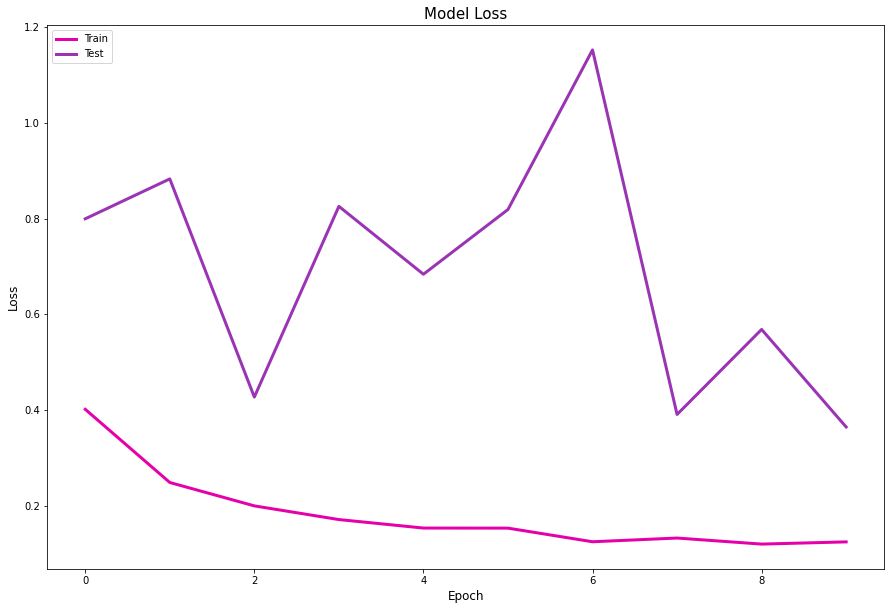

In [ ]:
loss(all_data)

Based on the result,  Adam is much faster than SGD and the model converges in earlier epochs in comparison to SGD. Moreover, it works fine with default hyperparmeters.

### __Question 7__

In [ ]:
train_model = neural_network(4800, 3200, 1600, optimizer=optimizers.Adam())  
all_data = train_model.fit(train_scale, validation_data=test_scale, epochs=20)

Epoch 1/20
163/163 [==============================] - 56s 341ms/step - loss: 0.6661 - accuracy: 0.8443 - val_loss: 0.6983 - val_accuracy: 0.7340
Epoch 2/20
163/163 [==============================] - 55s 337ms/step - loss: 0.1732 - accuracy: 0.9321 - val_loss: 0.3726 - val_accuracy: 0.8285
Epoch 3/20
163/163 [==============================] - 55s 338ms/step - loss: 0.1571 - accuracy: 0.9377 - val_loss: 0.8407 - val_accuracy: 0.7676
Epoch 4/20
163/163 [==============================] - 55s 339ms/step - loss: 0.1409 - accuracy: 0.9467 - val_loss: 0.3919 - val_accuracy: 0.8125
Epoch 5/20
163/163 [==============================] - 57s 352ms/step - loss: 0.1471 - accuracy: 0.9473 - val_loss: 1.3442 - val_accuracy: 0.6875
Epoch 6/20
163/163 [==============================] - 63s 386ms/step - loss: 0.1557 - accuracy: 0.9423 - val_loss: 0.6627 - val_accuracy: 0.7837
Epoch 7/20
163/163 [==============================] - 57s 350ms/step - loss: 0.1374 - accuracy: 0.9459 - val_loss: 0.5105 - val_ac

In [ ]:
prediction(train_model, test_scale)

20/20 [==============================] - 5s 246ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.36      0.52       234
         1.0       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.68      0.68       624
weighted avg       0.80      0.75      0.72       624



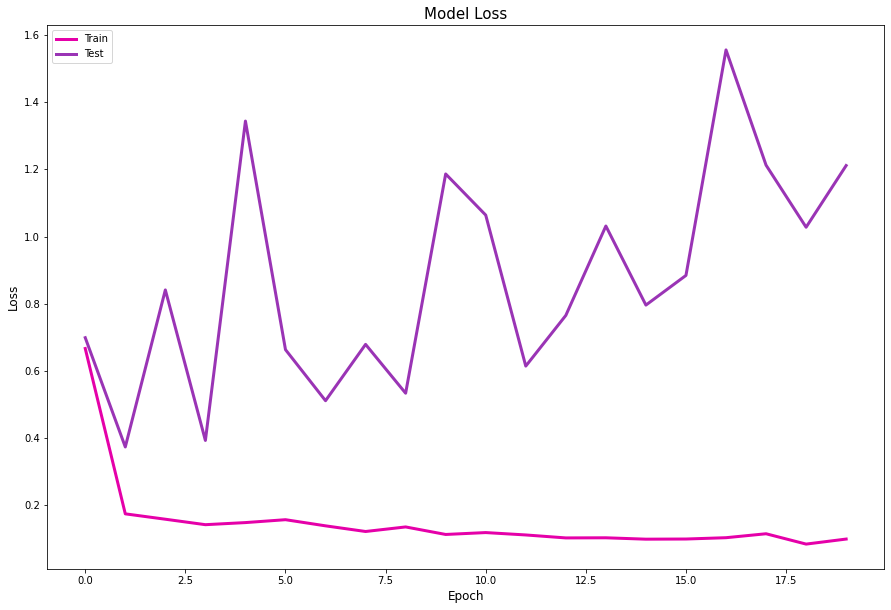

In [ ]:
loss(all_data)

#### __Why we train neural network for multiple epochs?__
In each epoch, weights are updated for several times and the whole data is checked. It is undeniable that we want to get good performance on non-training data and usually that takes more than one pass over the training data. Moreover, it is typical that gradient descent does not reach a global or local minimum after the first epoch. So, training just one epoch can lead to underfitting. As a result, we use multiple epochs.


#### __Is it always good to train for more epochs?__
If we set the number of epochs to a very large number, it may lead to have and overfitted model, because we train the data for many times and our model will start to model the noises in our data and it is a sign of overfitting and the accuracy of the test data will be reduced.

#### __Techniques to avoid overfitting by controlling the number of epochs:__
*   **Early stopping:** in this case we set the number of epochs to a really high number and you turn off the training when the improvement over next epochs is not satisfying. 
*   **Model Checkpoint:** here we once again set up a really high number of epochs and we simply save only the best model to a metric chosen. Once again we have a special callback for this scenario.

### __Question 8__

#### __Why MSE loss function is not good for classification problems?__
There are two reasons that  MSE loss function is not good for classification problems:

Firstly, when we use MSE, it means we assume the underlying data has been generated from a normal distribution. In Bayesian terms this means we assume a Gaussian prior. While in fact, our dataset can be classified into three categories. As a result, it is not from a normal distribution.

Secondly, the MSE function is non-convex for classification. In other words, if a classification model is trained with MSE loss function, it is not guaranteed to minimize the loss function. This is because MSE function expects real-valued inputs in range (-∞, ∞), while classification models output probabilities in range (0,1) through the activation function.


#### __In which problems we use MSE loss function?__
We use this loss function for regression problems.


In [ ]:
mse_loss_train_model = neural_network(4800, 3200, 1600, optimizer=optimizers.Adam(), loss=losses.mse)  
all_data = mse_loss_train_model.fit(train_scale, validation_data=test_scale, epochs=20)

Epoch 1/20
163/163 [==============================] - 56s 343ms/step - loss: 0.2573 - accuracy: 0.7402 - val_loss: 0.3750 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 55s 336ms/step - loss: 0.2571 - accuracy: 0.7429 - val_loss: 0.3750 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 56s 342ms/step - loss: 0.2571 - accuracy: 0.7429 - val_loss: 0.3750 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 58s 353ms/step - loss: 0.2571 - accuracy: 0.7429 - val_loss: 0.3750 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 55s 337ms/step - loss: 0.2571 - accuracy: 0.7429 - val_loss: 0.3750 - val_accuracy: 0.6250
Epoch 6/20
163/163 [==============================] - 55s 335ms/step - loss: 0.2571 - accuracy: 0.7429 - val_loss: 0.3750 - val_accuracy: 0.6250
Epoch 7/20
163/163 [==============================] - 55s 335ms/step - loss: 0.2571 - accuracy: 0.7429 - val_loss: 0.3750 - val_ac

In [ ]:
prediction(mse_loss_train_model, test_scale)

20/20 [==============================] - 5s 254ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       234
         1.0       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


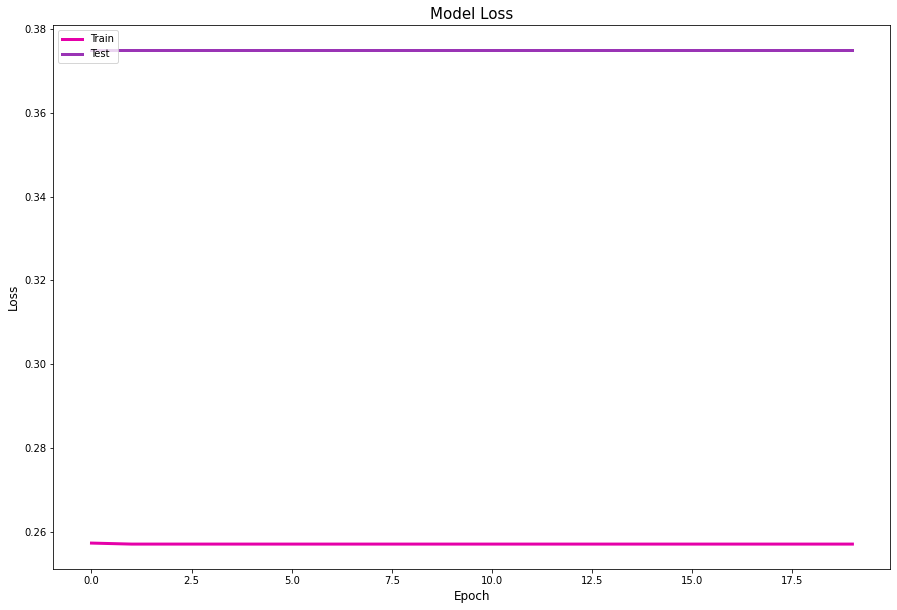

In [ ]:
loss(all_data)

Based on the result, by using this loss function, the rate of the learning process decreased and it seems that it will not converge and it refers to the reasons that we mentioned above.

### __Question 9__

As we mentioned in previous parts, if we train our model for more epochs, the risk of overfitting will be increased. One of the techniques to avoid overfitting is to use regularization methods that we want to discuss in this part.

#### __Using Regularization__


In [ ]:
regularization_train_model = neural_network(4800, 3200, 1600, optimizer=optimizers.Adam(), regularizer=regularizers.l2(0.0001))  
all_data = regularization_train_model.fit(train_scale, validation_data=test_scale, epochs=20)

Epoch 1/20
163/163 [==============================] - 56s 342ms/step - loss: 1.6009 - accuracy: 0.8535 - val_loss: 1.3357 - val_accuracy: 0.7532
Epoch 2/20
163/163 [==============================] - 58s 357ms/step - loss: 0.6524 - accuracy: 0.9348 - val_loss: 0.8714 - val_accuracy: 0.8173
Epoch 3/20
163/163 [==============================] - 56s 345ms/step - loss: 0.5376 - accuracy: 0.9354 - val_loss: 0.6719 - val_accuracy: 0.8462
Epoch 4/20
163/163 [==============================] - 56s 345ms/step - loss: 0.4650 - accuracy: 0.9362 - val_loss: 1.1112 - val_accuracy: 0.7788
Epoch 5/20
163/163 [==============================] - 57s 348ms/step - loss: 0.3836 - accuracy: 0.9463 - val_loss: 0.9581 - val_accuracy: 0.7612
Epoch 6/20
 87/163 [===============>..............] - ETA: 23s - loss: 0.3555 - accuracy: 0.9526

In [ ]:
prediction(regularization_train_model, test_scale)

In [ ]:
loss(all_data)

Based on the result, the loss curve is smoother and it shows that our model has not faced with overfitting, during the learning process.

#### __Using Dropout Layers__

In [ ]:
train_model = neural_network_drop(4800, 3200, 1600, 0.1, optimizer=optimizers.Adam())  
all_data = train_model.fit(train_scale, validation_data=test_scale, epochs=20)

In [ ]:
prediction(train_model, test_scale)

In [ ]:
loss(all_data)

Here, the loss curve is smoother than the previous part and it seems that this method can deal with overfitting in a better way.

### __Conclusion__
<br/>
<div style="text-align: justify;"> 
In this computer assignment we learned that neural networks are good methods to solve image classification problems. Moreover, we were introduced to the method of Keras library. Finally, we learned how to tune the parameters in order to reach an optimal model.
</div>